In [1]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from torchvision import models

In [2]:
# Preprocess the image for the model
def preprocess_image(img_path):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img = Image.open(img_path).convert('RGB')
    input_tensor = preprocess(img).unsqueeze(0)  # Add batch dimension
    return input_tensor, img

# Generate Saliency Map
def saliency_map(model, input_tensor, device):
    input_tensor.requires_grad_()  # Enable gradients on input
    model.eval()
    input_tensor = input_tensor.to(device)

    # Forward pass
    output = model(input_tensor)
    output.backward()  # Backpropagate to compute gradients

    # Calculate saliency map (maximum gradient magnitude)
    saliency = input_tensor.grad.abs().squeeze().cpu().numpy()  # Take the gradient magnitude
    saliency = np.max(saliency, axis=0)  # Take the max across the channel dimension (RGB)
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())  # Normalize to [0, 1]
    return saliency

In [6]:
# 2. VGG-16 Model
import torch.nn as nn
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 1)  # Outputting head count as a single value
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [7]:
# Load the trained model
model_path = "Models/vgg16_headcount (1).pth"
device = torch.device("cpu")  # Force CPU even if CUDA is available
model = VGG16().to(device)
# model.load_state_dict(torch.load(model_path))
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)

C:\Users\harin\AppData\Local\Temp\ipykernel_18776\503125403.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=dev

VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [8]:
# Path to the image for visualization
img_path = "data/Classroom-Data/images13.6/images/img265.jpg"
input_tensor, original_image = preprocess_image(img_path)

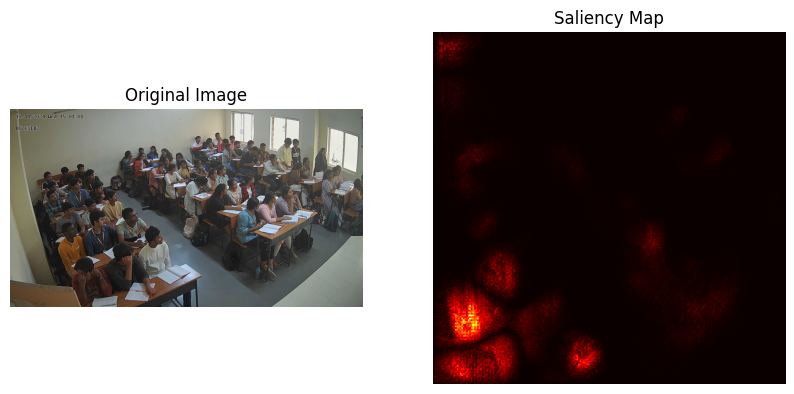

In [9]:
# Generate saliency map
saliency = saliency_map(model, input_tensor, device)

# Plot the results
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis("off")

# Saliency map
plt.subplot(1, 2, 2)
plt.title("Saliency Map")
plt.imshow(saliency, cmap="hot")
plt.axis("off")

plt.show()

In [10]:
def visualize_feature_maps(model, input_tensor, target_layer_name, device):
    activations = []

    def forward_hook(module, input, output):
        activations.append(output)

    # Register hook
    target_layer = dict(model.named_modules())[target_layer_name]
    target_layer.register_forward_hook(forward_hook)

    # Forward pass
    model.eval()
    input_tensor = input_tensor.to(device)
    model(input_tensor)

    # Visualize feature maps
    feature_maps = activations[0].squeeze().cpu().detach().numpy()
    num_maps = feature_maps.shape[0]

    plt.figure(figsize=(15, 15))
    for i in range(min(num_maps, 16)):  # Plot first 16 feature maps
        plt.subplot(4, 4, i+1)
        plt.imshow(feature_maps[i], cmap="viridis")
        plt.axis("off")
    plt.suptitle("Feature Maps")
    plt.show()

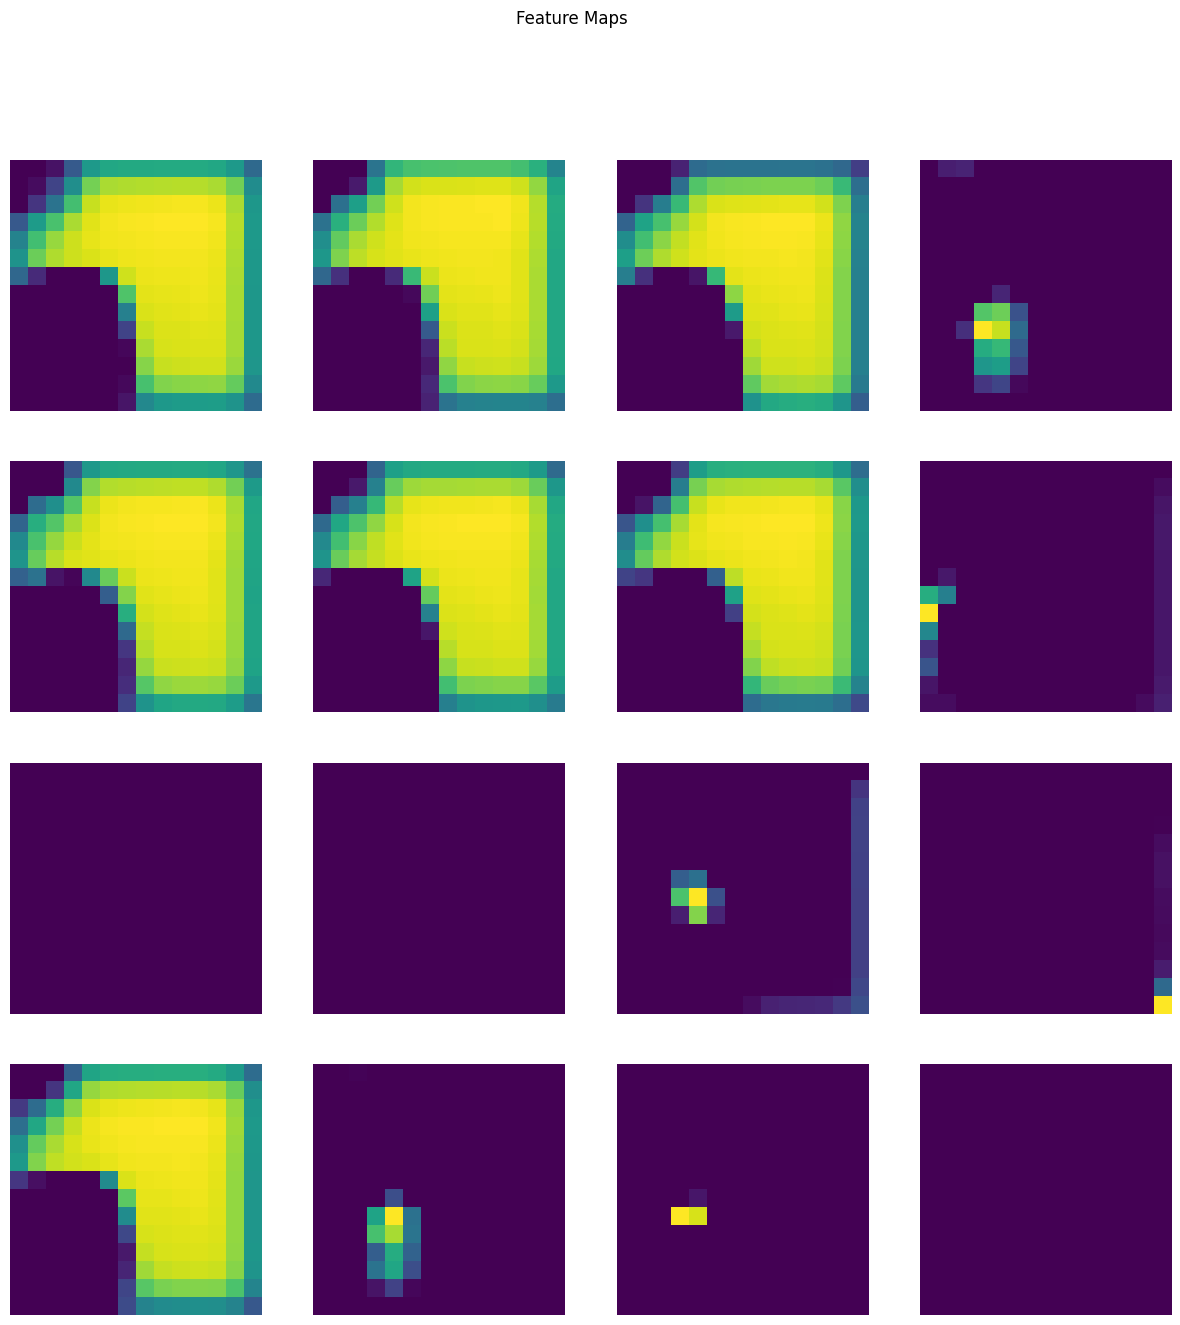

In [11]:
# Visualize feature maps for a specific layer
target_layer_name = "features.28"  # Example layer
visualize_feature_maps(model, input_tensor, target_layer_name, device)